In [1]:
%pwd

'/Users/uvaishnav/stress_detection/notebooks'

In [2]:
import os
os.chdir('../')
%pwd

'/Users/uvaishnav/stress_detection'

In [3]:
from StressDetection.entity.entity import WesadDataIngestionConfig
from StressDetection.config.configuration import ConfigurationManager
from StressDetection import logger


In [4]:
config = ConfigurationManager()
config = config.get_wesad_data_ingestion_config()

[2024-12-25 09:39:30,810: INFO: common: YAML file: config.yaml loaded successfully]
[2024-12-25 09:39:30,812: INFO: common: YAML file: params.yaml loaded successfully]


In [5]:
from pathlib import Path
import pickle
from typing import Dict

def load_subjects(subject_id: int) -> Dict:
        """
        Load data for a specific subject from pickle file.

        Args:
            subject_id (int): ID of the subject to load.

        Returns:
            Dict: Dictionary containing subject's sensor data and labels.

        Raises:
            ValueError: If subject_id is not in valid_subjects.
            FileNotFoundError: If subject's data file is not found.
            pickle.UnpicklingError: If there's an error reading the pickle file.
        """
        if subject_id not in config.valid_subjects:
            raise ValueError(f"Invalid subject ID: {subject_id}")
        
        data_source_path = Path(config.data_source_path)
        
        file_path = Path(data_source_path/f"S{subject_id}/S{subject_id}.pkl")
        
        try:
            with open(file_path, 'rb') as file:
                data = pickle.load(file, encoding='latin1')
            logger.info(f"Data loaded successfully for subject {subject_id}")
            logger.info(f"Data keys: {data.keys()}")
            return data
        except (FileNotFoundError, pickle.UnpicklingError) as e:
            logger.error(f"Error loading data for subject {subject_id}: {str(e)}")
            raise e

In [8]:
data = load_subjects(2)

[2024-12-25 09:40:34,013: INFO: 3002137152: Data loaded successfully for subject 2]
[2024-12-25 09:40:34,017: INFO: 3002137152: Data keys: dict_keys(['signal', 'label', 'subject'])]


In [18]:
data['label'].shape 

(4255300,)

In [11]:
print(data['signal'].keys())
print(data['signal']['wrist'].keys())

dict_keys(['chest', 'wrist'])
dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])


In [38]:
# Log the lengths of the signals to make sure they match
acc_data = data['signal']['wrist']['ACC']
eda_data = data['signal']['wrist']['EDA']
temp_data = data['signal']['wrist']['TEMP']
bvp_data = data['signal']['wrist']['BVP']

logger.info(f"Length of EDA data: {len(eda_data)}")
logger.info(f"Length of TEMP data: {len(temp_data)}")
logger.info(f"Length of ACC data: {len(acc_data)}")
logger.info(f"Length of BVP data: {len(bvp_data)}")

[2024-12-25 10:41:40,830: INFO: 3230937383: Length of EDA data: 24316]
[2024-12-25 10:41:40,834: INFO: 3230937383: Length of TEMP data: 24316]
[2024-12-25 10:41:40,835: INFO: 3230937383: Length of ACC data: 194528]
[2024-12-25 10:41:40,835: INFO: 3230937383: Length of BVP data: 389056]


In [13]:
import matplotlib.pyplot as plt

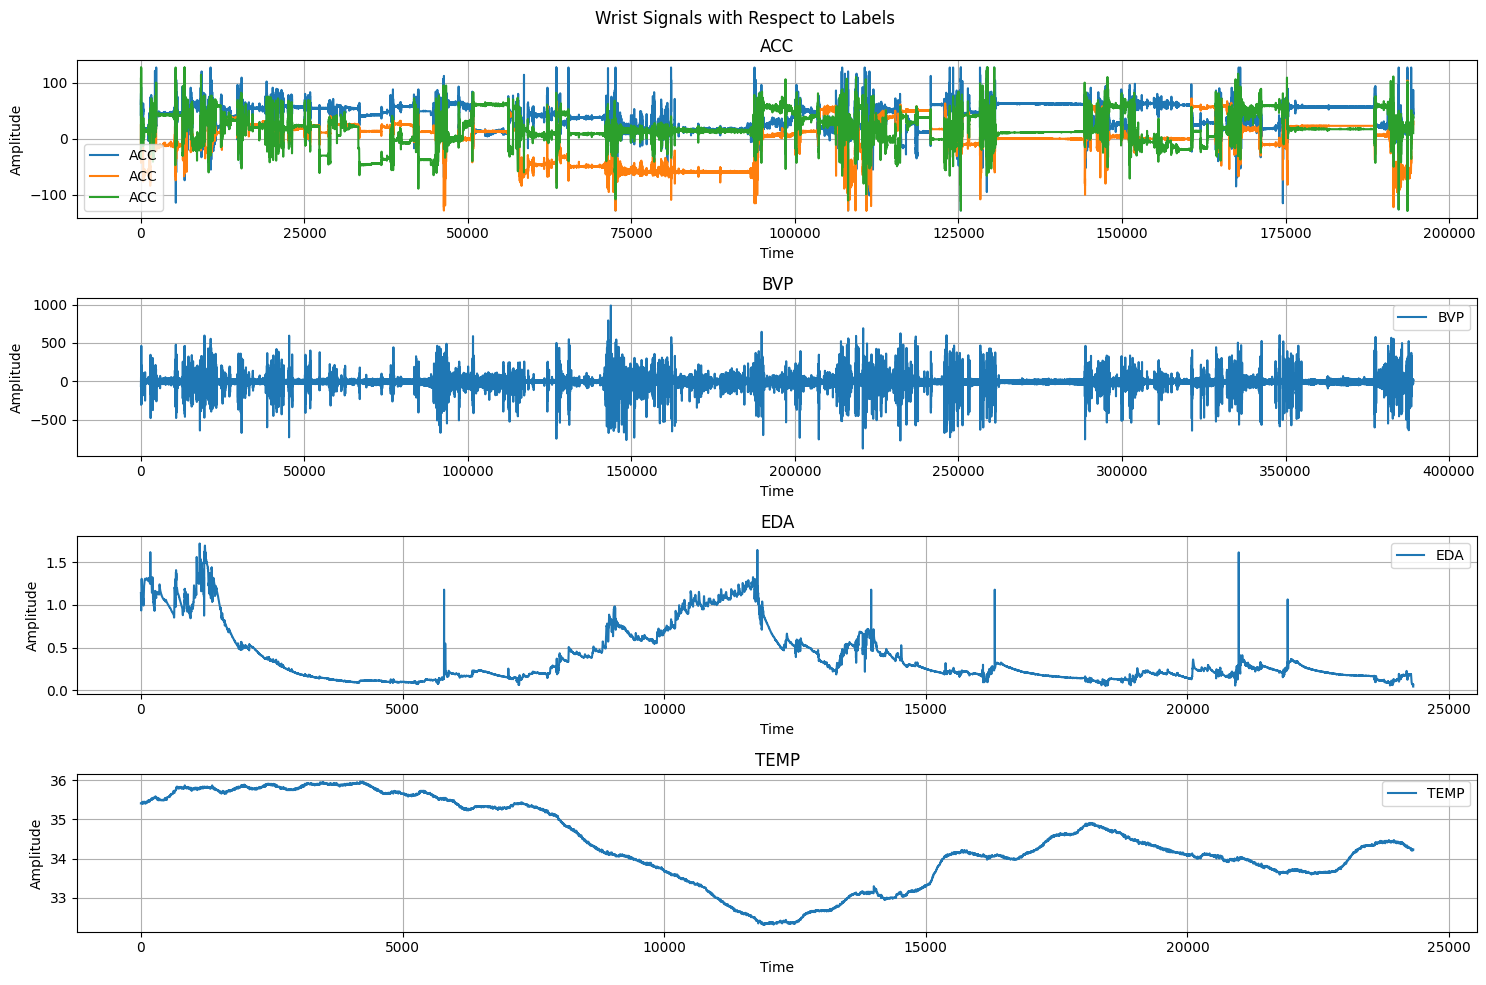

In [14]:
import matplotlib.pyplot as plt

# Extract wrist signals and labels
wrist_signals = data['signal']['wrist']
labels = data['label']

# Plot each wrist signal
fig, axs = plt.subplots(len(wrist_signals), 1, figsize=(15, 10))
fig.suptitle('Wrist Signals with Respect to Labels')

for i, (signal_name, signal_data) in enumerate(wrist_signals.items()):
    axs[i].plot(signal_data, label=signal_name)
    axs[i].set_title(signal_name)
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Amplitude')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

In [62]:
def validate_wrist_data(data: Dict) -> bool:
        """
        Validate the wrist sensor data for required signals and sampling rates.

        Args:
            data (Dict): Dictionary containing wrist sensor data.

        Returns:
            bool: True if data meets all validation criteria, False otherwise.
        """
        try:
            wrist_data = data['signal']['wrist']
            
            # Check for required signals
            if not all(signal in wrist_data for signal in config.required_signals):
                logger.warning("Missing required signals in wrist data")
                return False
            
            # Validate signal lengths
            label_length = len(data['label'])
            for signal, rate in config.sampling_rates['wrist'].items():
                logger.info(f"Signal: {signal}, Rate: {rate}")
                # Ensure rate is numeric
                if isinstance(rate, str):
                    rate = float(rate)  # Convert rate to a float
                expected_length = label_length * (rate / 700)  # 700Hz is label rate
                actual_length = len(wrist_data[signal])
                
                if abs(expected_length - actual_length) > rate:
                    logger.warning(f"Signal length mismatch for {signal}")
                    return False
            logger.info("Wrist data validation successful")
            return True
        except KeyError as e:
            logger.error(f"Data structure error: {str(e)}")
            return False


In [63]:
import pandas as pd
import numpy as np
from typing import Tuple

In [106]:
def handle_missing_values(df: pd.DataFrame, subject_id: int) -> pd.DataFrame:
        """Handle missing values in the DataFrame using linear interpolation."""
        if df.isnull().any().any():
            logger.warning(f"Missing values detected for subject {subject_id}")
            return df.interpolate(method='linear')
        return df

def normalize_signal_lengths(data: Dict) -> Dict:
    """Normalize all signals to target length based on common sampling rate."""
    target_length = int(len(data['label']) * (config.common_sampling_rate / 700))
    normalized_data = {}
    
    # Debug signal shapes
    for signal, rate in config.sampling_rates['wrist'].items():
        if signal == 'ACC':
            acc_data = data['signal']['wrist']['ACC']
            logger.info(f"ACC shape: {acc_data.shape}")
            for i, axis in enumerate(['X', 'Y', 'Z']):
                temp_series = pd.Series(acc_data[:, i].flatten())  # Flatten array
                window = int(rate / config.common_sampling_rate)
                resampled = apply_rolling_mean(temp_series, window)
                normalized_data[f'ACC_{axis}'] = resampled.iloc[::window][:target_length].values
        else:
            signal_data = data['signal']['wrist'][signal]
            logger.info(f"{signal} shape: {signal_data.shape}")
            # Flatten if multi-dimensional
            if len(signal_data.shape) > 1:
                signal_data = signal_data.flatten()
                
            temp_series = pd.Series(signal_data)
            window = int(rate / config.common_sampling_rate)
            resampled = apply_rolling_mean(temp_series, window)
            normalized_data[signal] = resampled.iloc[::window][:target_length].values
        
        # Verify length
        # For ACC signals, check all three axes
        if signal == 'ACC':
            for axis in ['X', 'Y', 'Z']:
                if len(normalized_data[f'ACC_{axis}']) != target_length:
                    raise ValueError(f"Length mismatch for ACC_{axis}: Expected {target_length}, got {len(normalized_data[f'ACC_{axis}'])}")
        else:
            if len(normalized_data[signal]) != target_length:
                raise ValueError(f"Length mismatch for {signal}: Expected {target_length}, got {len(normalized_data[signal])}")
    
    return normalized_data


def apply_rolling_mean(series: pd.Series, window: int) -> pd.Series:
        """Apply rolling mean to a time series."""
        return series.rolling(
            window=window,
            min_periods=1,
            center=True
        ).mean()


def process_labels(labels: np.ndarray, target_length: int) -> np.ndarray:
    """
    Process labels from 700Hz to 4Hz(common sampling rate) sampling rate.
    
    Args:
        labels: Raw labels at 700Hz
        target_length: Required length at common sampling rate 
    """
    # Calculate downsampling parameters
    downsample_factor = 700//config.common_sampling_rate
    
    # Create DataFrame for rolling operations
    labels_df = pd.DataFrame(labels, columns=['label'])
    
    # Apply rolling window with majority vote
    labels_resampled = labels_df.rolling(
        window=downsample_factor,
        min_periods=int(downsample_factor * 0.8),  # 80% minimum samples
        center=True  # Center window for better temporal alignment
    ).apply(lambda x: np.bincount(x.astype(int)).argmax())
    
    # Downsample by selecting every Nth sample
    labels_downsampled = labels_resampled.iloc[::downsample_factor].reset_index(drop=True)
    
    # Convert to binary (stress vs non-stress)
    labels_binary = (labels_downsampled == 2).astype(int)
    
    # Ensure correct length
    if len(labels_binary) < target_length:
        raise ValueError(f"Insufficient labels after processing: {len(labels_binary)} < {target_length}")
    
    return labels_binary[:target_length].to_numpy()

In [107]:
def extract_wrist_data(subject_id: int) -> Tuple[pd.DataFrame, np.ndarray]:
        """
        Extract and process wrist sensor data and stress labels.
        
        Args:
            subject_id (int): Subject identifier
            
        Returns:
            Tuple[pd.DataFrame, np.ndarray]: Processed sensor data and binary labels
            
        Raises:
            ValueError: If data validation fails or there's a length mismatch
        """
        try:
            data = load_subjects(subject_id)
            if not validate_wrist_data(data):
                raise ValueError(f"Invalid wrist data for subject {subject_id}")
            
            # Normalize signal lengths
            normalized_data = normalize_signal_lengths(data)

            logger.info(f"Normalized data keys: {normalized_data.keys()}")
            logger.info(f"Normalized data lengths for BVP: {len(normalized_data['BVP'])}")
            logger.info(f"Normalized data lengths for ACC_X: {len(normalized_data['ACC_X'])}")
            logger.info(f"Normalized data lengths for ACC_Y: {len(normalized_data['ACC_Y'])}")
            logger.info(f"Normalized data lengths for ACC_Z: {len(normalized_data['ACC_Z'])}")
            logger.info(f"Normalized data lengths for TEMP: {len(normalized_data['TEMP'])}")
            logger.info(f"Normalized data lengths for EDA: {len(normalized_data['EDA'])}")
            logger.info(f"Label length: {len(data['label'])}")
            logger.info(f"Label shape: {data['label'].shape}")


            # Create and process DataFrame
            df = pd.DataFrame(normalized_data)
            logger.info(f"DataFrame columns: {df.columns}")
            logger.info(f"Length of BVP data: {len(df['BVP'])}")
            print(df.head())
            logger.info(f"DataFrame shape: {df.shape}")
            df = handle_missing_values(df, subject_id)
            
            logger.info(f"DataFrame shape after handling missing values: {df.shape}")
            print(df.head())

            # Process labels
            labels_final = process_labels(data['label'], len(df))
            
            return df, labels_final
            
        except Exception as e:
            logger.error(f"Error processing subject {subject_id}: {str(e)}")
            raise

In [114]:
def plot_signals(df: pd.DataFrame, labels: np.ndarray) -> None:
        """Plot all signals with stress annotations"""
        fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
        
        signals = ['BVP', 'EDA', 'TEMP', 'ACC_X']
        for ax, signal in zip(axes, signals):
            ax.plot(df[signal], label=signal)
            ax.set_ylabel(signal)
            
            # Highlight stress regions
            stress_regions = np.where(labels == 1)[0]
            for region in stress_regions:
                ax.axvspan(region, region+1, color='red', alpha=0.2)
        
        plt.xlabel('Time (samples)')
        plt.tight_layout()
        plt.show()

In [111]:
df, labels = extract_wrist_data(2)

# Display data info
print(f"Data shape: {df.shape}")
print(f"Signals: {df.columns.tolist()}")
print(f"Number of stress samples: {sum(labels)}")


[2024-12-25 16:50:10,413: INFO: 3002137152: Data loaded successfully for subject 2]
[2024-12-25 16:50:10,418: INFO: 3002137152: Data keys: dict_keys(['signal', 'label', 'subject'])]
[2024-12-25 16:50:10,420: INFO: 4160589071: Signal: ACC, Rate: 32]
[2024-12-25 16:50:10,420: INFO: 4160589071: Signal: BVP, Rate: 64]
[2024-12-25 16:50:10,420: INFO: 4160589071: Signal: EDA, Rate: 4]
[2024-12-25 16:50:10,420: INFO: 4160589071: Signal: TEMP, Rate: 4]
[2024-12-25 16:50:10,421: INFO: 4160589071: Wrist data validation successful]
[2024-12-25 16:50:10,421: INFO: 2865832398: ACC shape: (194528, 3)]
[2024-12-25 16:50:10,432: INFO: 2865832398: BVP shape: (389056, 1)]
[2024-12-25 16:50:10,437: INFO: 2865832398: EDA shape: (24316, 1)]
[2024-12-25 16:50:10,439: INFO: 2865832398: TEMP shape: (24316, 1)]
[2024-12-25 16:50:10,439: INFO: 2483276463: Normalized data keys: dict_keys(['ACC_X', 'ACC_Y', 'ACC_Z', 'BVP', 'EDA', 'TEMP'])]
[2024-12-25 16:50:10,440: INFO: 2483276463: Normalized data lengths for BV

In [112]:
print(f"Percentage of stress samples: {100 * np.sum(labels) / len(labels):.2f}%")

Percentage of stress samples: 10.12%


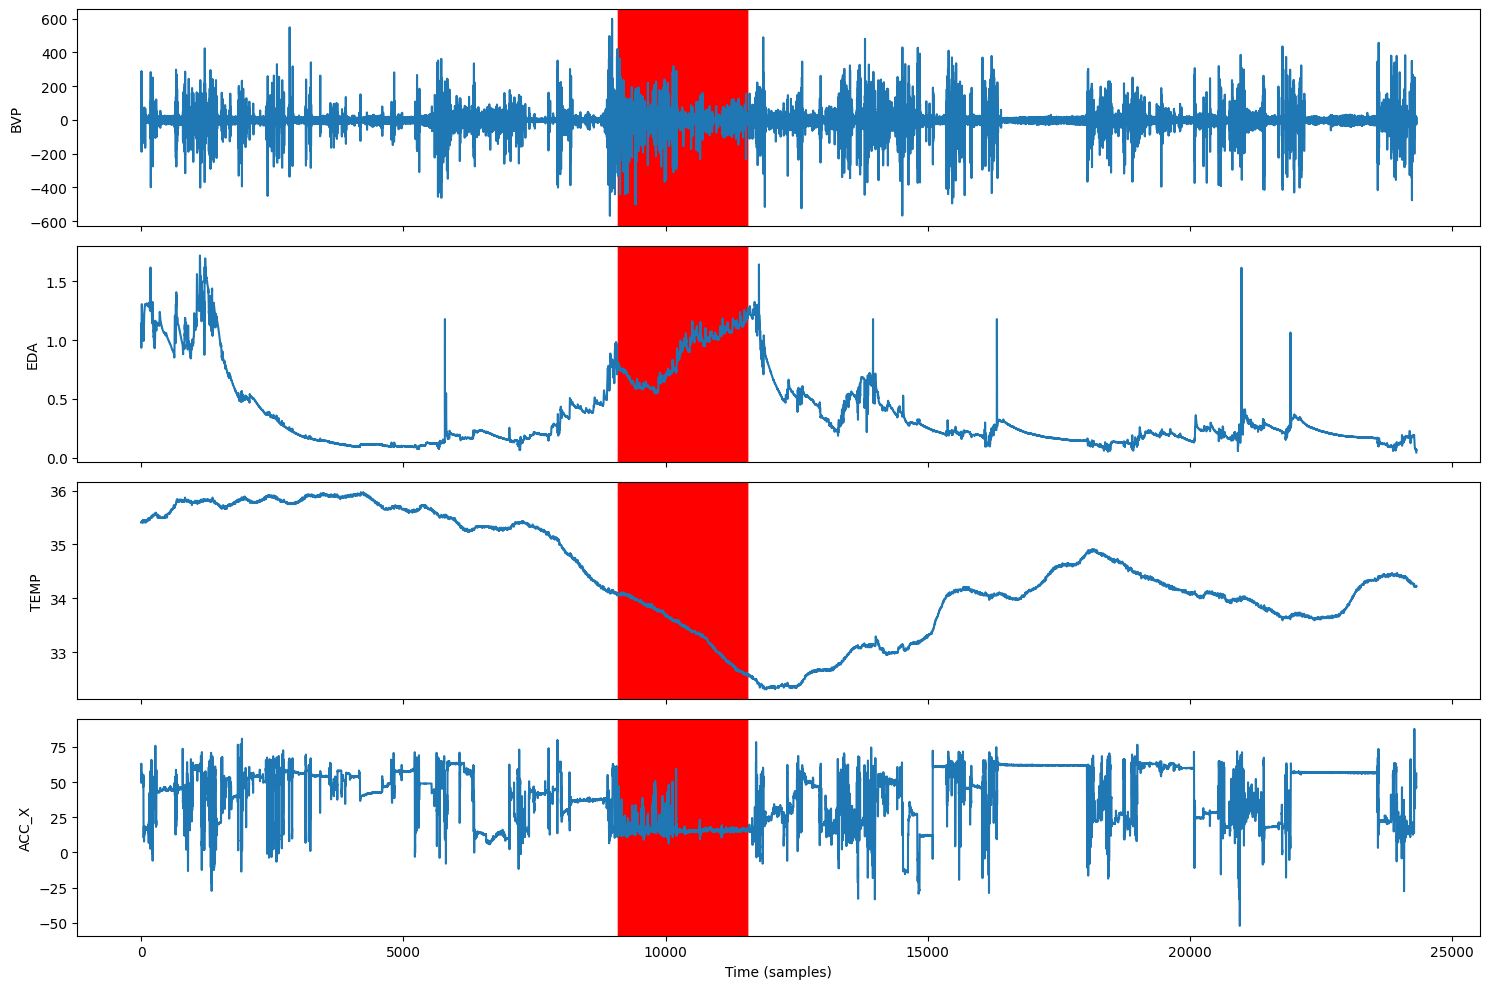

In [115]:
plot_signals(df, labels)

## Statastics of Overall Data

In [119]:
complete_data = pd.read_csv('data/processed/WESAD/processed_data.csv')

In [120]:
labels = complete_data['stress_label']

In [121]:
print("Total number of samples:", len(labels))
print(f"Number of stress samples: {sum(labels)}")
print(f"Percentage of stress samples: {100 * np.sum(labels) / len(labels):.2f}%")

Total number of samples: 347472
Number of stress samples: 39864
Percentage of stress samples: 11.47%


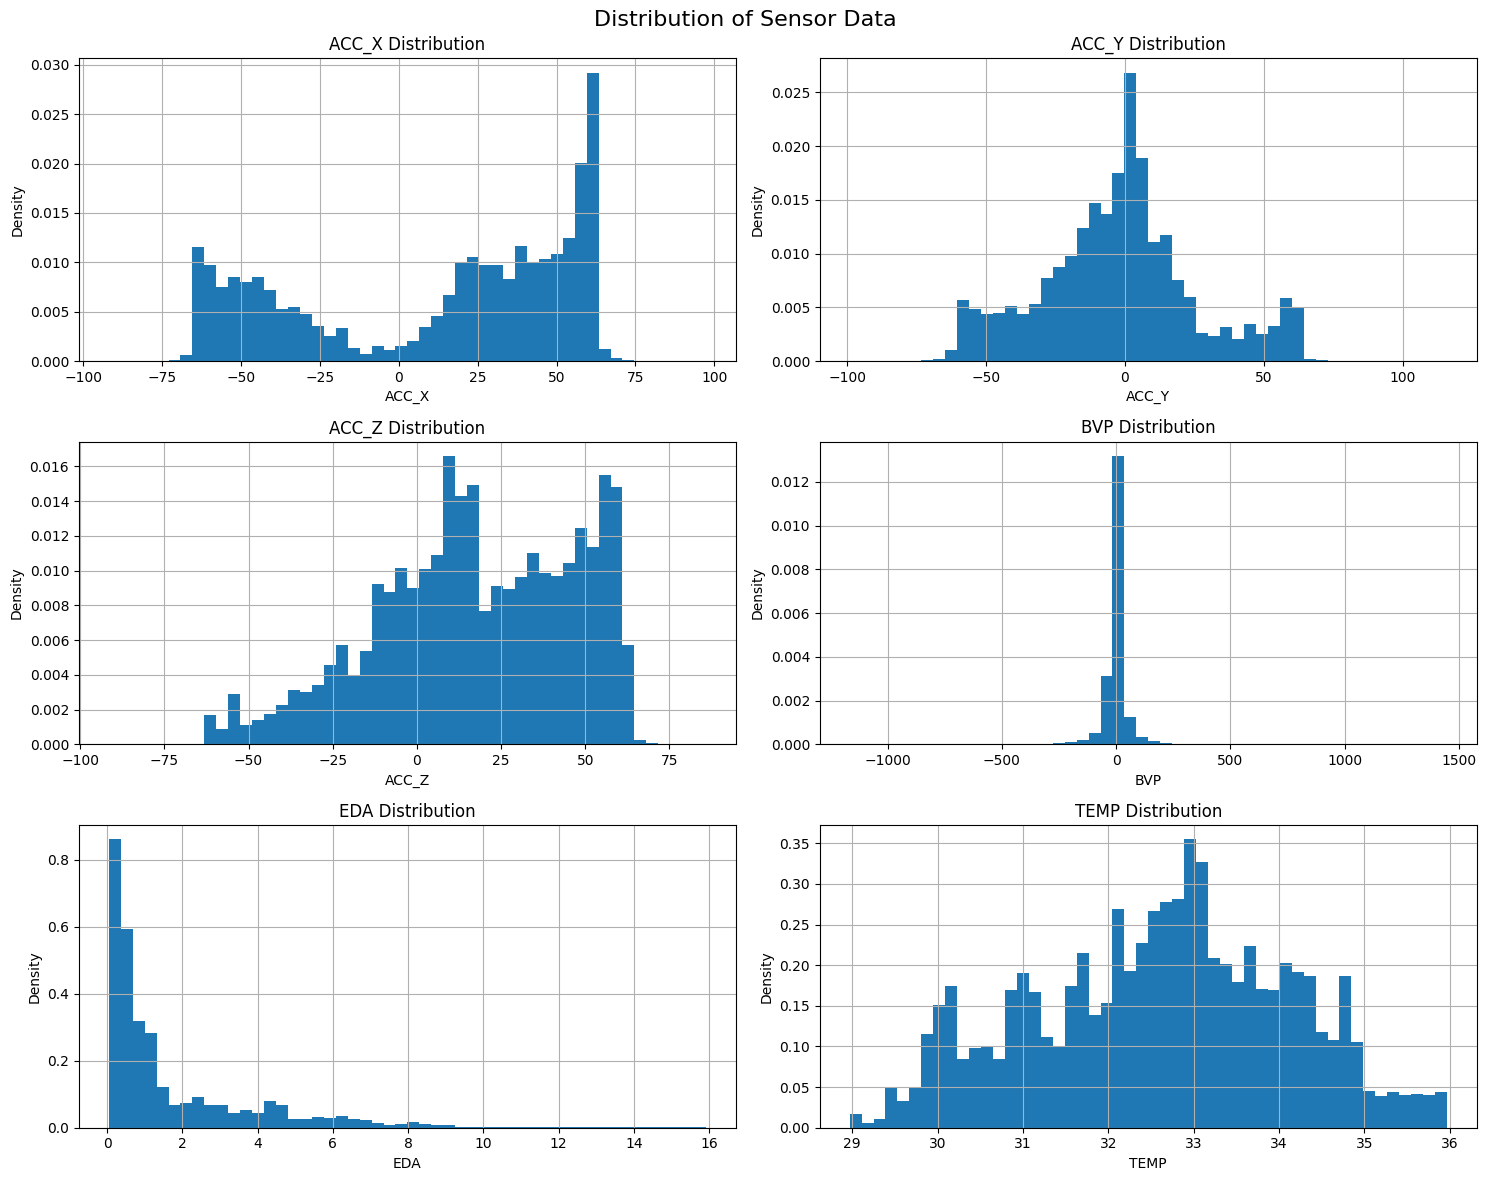

In [122]:
# Create subplots for each signal
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Distribution of Sensor Data', fontsize=16)

# Flatten axes for easier iteration
axes = axes.flatten()

# Plot histograms for each signal
signals = ['ACC_X', 'ACC_Y', 'ACC_Z', 'BVP', 'EDA', 'TEMP']
for i, signal in enumerate(signals):
    axes[i].hist(complete_data[signal], bins=50, density=True)
    axes[i].set_title(f'{signal} Distribution')
    axes[i].set_xlabel(signal)
    axes[i].set_ylabel('Density')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

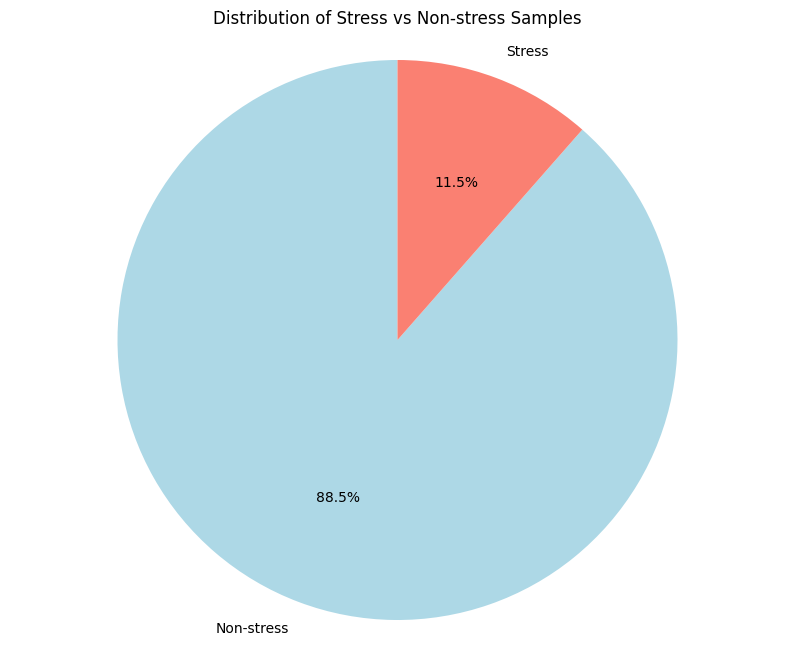


Class Distribution Statistics:
------------------------------
Total samples: 347,472
Class 0: 307,608 samples (88.5%)
Class 1: 39,864 samples (11.5%)


In [123]:
# Calculate and display class distribution
stress_distribution = complete_data['stress_label'].value_counts()
class_percentages = 100 * stress_distribution / len(complete_data)

# Create a pie chart
plt.figure(figsize=(10, 8))
plt.pie(class_percentages, 
    labels=['Non-stress', 'Stress'],
    autopct='%1.1f%%',
    colors=['lightblue', 'salmon'],
    startangle=90)
plt.title('Distribution of Stress vs Non-stress Samples')
plt.axis('equal')
plt.show()

# Print detailed statistics
print("\nClass Distribution Statistics:")
print("-" * 30)
print(f"Total samples: {len(complete_data):,}")
for label, count in stress_distribution.items():
    print(f"Class {label}: {count:,} samples ({count/len(complete_data)*100:.1f}%)")

# Trail Code

In [124]:
def visualize_rolling_mean():
    
    # Sample BVP signal
    time = np.linspace(0, 10, 640)  # 10 seconds at 64Hz
    bvp = np.sin(2*np.pi*1.2*time) + 0.5*np.random.randn(len(time))
    
    # Apply rolling mean
    window = 16  # 64Hz to 4Hz
    bvp_resampled = pd.Series(bvp).rolling(window=window, center=True).mean()
    
    plt.figure(figsize=(12, 6))
    plt.plot(time, bvp, 'b-', label='Original (64Hz)', alpha=0.5)
    plt.plot(time[::window], bvp_resampled[::window], 'r-', label='Resampled (4Hz)')
    plt.title('BVP Signal Resampling using Rolling Mean')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

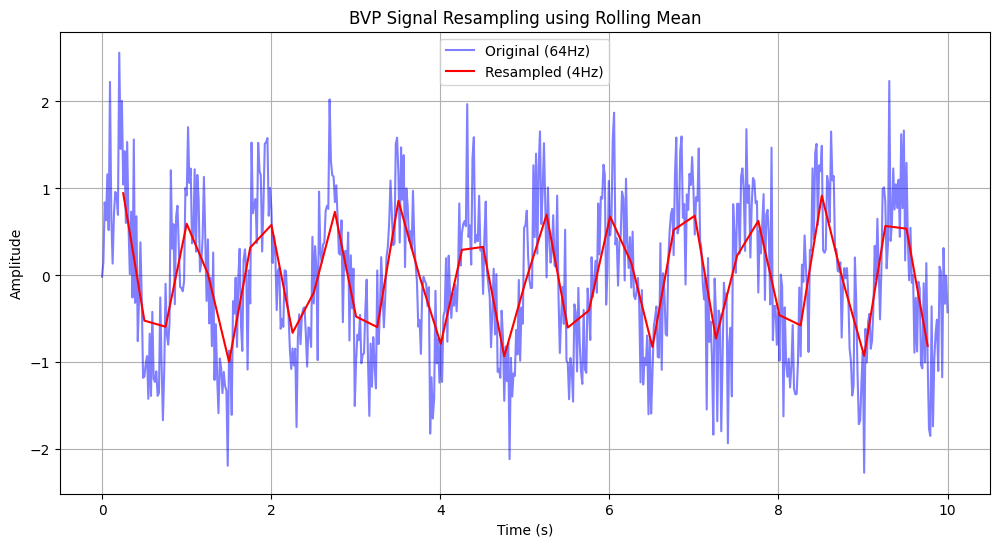

In [125]:
visualize_rolling_mean()

## Importance of Rolling Mean in Signal Processing

In signal processing, the rolling mean (or moving average) is a powerful technique used to smooth out short-term fluctuations and highlight longer-term trends or cycles. This is particularly useful when dealing with noisy data, such as physiological signals.

### Example: BVP Signal Resampling

The plot below demonstrates the effect of applying a rolling mean to a Blood Volume Pulse (BVP) signal. The original BVP signal, sampled at 64Hz, contains a significant amount of noise. By applying a rolling mean with a window size of 16 (to downsample to 4Hz), we can effectively reduce the noise and obtain a smoother signal that is easier to analyze.

In the plot:
- The blue line represents the original BVP signal sampled at 64Hz.
- The red line represents the resampled BVP signal after applying the rolling mean, effectively reducing the sampling rate to 4Hz.

As seen in the plot, the rolling mean helps in reducing the noise and preserving the essential characteristics of the signal, making it more suitable for further analysis and interpretation.

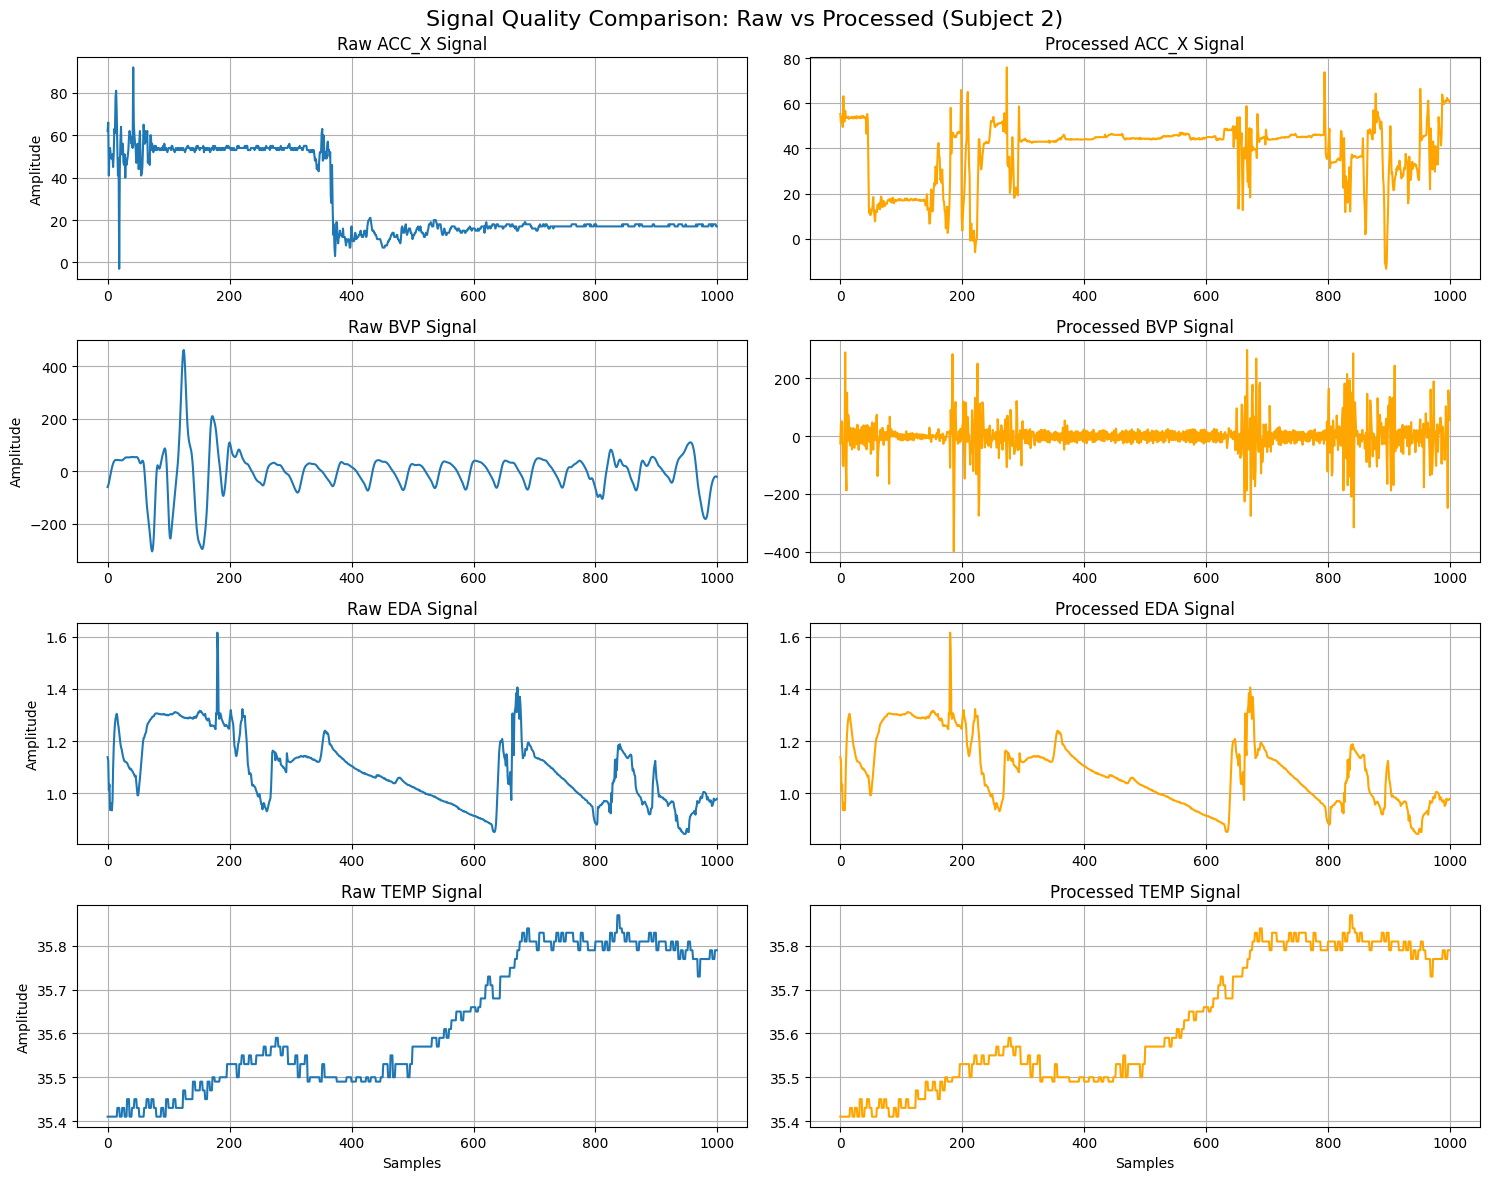


Signal Statistics:
--------------------------------------------------

ACC_X:
    Raw - Mean: 39.70, Std: 19.52
    Processed - Mean: 39.70, Std: 18.93

BVP:
    Raw - Mean: -0.00, Std: 75.87
    Processed - Mean: -0.00, Std: 62.95

EDA:
    Raw - Mean: 0.39, Std: 0.33
    Processed - Mean: 0.39, Std: 0.33

TEMP:
    Raw - Mean: 34.39, Std: 1.05
    Processed - Mean: 34.39, Std: 1.05


In [127]:
def visualize_signal_quality_comparison(raw_data, processed_df):
    """
    Visualize the comparison between raw and processed signals for subject 2.
    
    Args:
        raw_data: Dictionary containing raw signals
        processed_df: DataFrame containing processed signals
    """
    # Create figure with subplots for each signal
    fig, axes = plt.subplots(4, 2, figsize=(15, 12))
    fig.suptitle('Signal Quality Comparison: Raw vs Processed (Subject 2)', fontsize=16)
    
    # Plot ACC (using X-axis as example)
    axes[0,0].plot(raw_data['signal']['wrist']['ACC'][:1000,0], label='Raw')
    axes[0,0].set_title('Raw ACC_X Signal')
    axes[0,0].set_ylabel('Amplitude')
    axes[0,0].grid(True)
    
    axes[0,1].plot(processed_df['ACC_X'][:1000], label='Processed', color='orange')
    axes[0,1].set_title('Processed ACC_X Signal')
    axes[0,1].grid(True)
    
    # Plot BVP
    axes[1,0].plot(raw_data['signal']['wrist']['BVP'][:1000], label='Raw')
    axes[1,0].set_title('Raw BVP Signal')
    axes[1,0].set_ylabel('Amplitude')
    axes[1,0].grid(True)
    
    axes[1,1].plot(processed_df['BVP'][:1000], label='Processed', color='orange')
    axes[1,1].set_title('Processed BVP Signal')
    axes[1,1].grid(True)
    
    # Plot EDA
    axes[2,0].plot(raw_data['signal']['wrist']['EDA'][:1000], label='Raw')
    axes[2,0].set_title('Raw EDA Signal')
    axes[2,0].set_ylabel('Amplitude')
    axes[2,0].grid(True)
    
    axes[2,1].plot(processed_df['EDA'][:1000], label='Processed', color='orange')
    axes[2,1].set_title('Processed EDA Signal')
    axes[2,1].grid(True)
    
    # Plot TEMP
    axes[3,0].plot(raw_data['signal']['wrist']['TEMP'][:1000], label='Raw')
    axes[3,0].set_title('Raw TEMP Signal')
    axes[3,0].set_ylabel('Amplitude')
    axes[3,0].set_xlabel('Samples')
    axes[3,0].grid(True)
    
    axes[3,1].plot(processed_df['TEMP'][:1000], label='Processed', color='orange')
    axes[3,1].set_title('Processed TEMP Signal')
    axes[3,1].set_xlabel('Samples')
    axes[3,1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nSignal Statistics:")
    print("-" * 50)
    for signal in ['ACC_X', 'BVP', 'EDA', 'TEMP']:
        if signal == 'ACC_X':
            raw_stats = pd.Series(raw_data['signal']['wrist']['ACC'][:,0]).describe()
        else:
            raw_stats = pd.Series(raw_data['signal']['wrist'][signal].flatten()).describe()
        proc_stats = processed_df[signal].describe()
        
        print(f"\n{signal}:")
        print(f"{'':4}Raw - Mean: {raw_stats['mean']:.2f}, Std: {raw_stats['std']:.2f}")
        print(f"{'':4}Processed - Mean: {proc_stats['mean']:.2f}, Std: {proc_stats['std']:.2f}")

# Call the function with the existing data
visualize_signal_quality_comparison(data, df)

"""
Signal Quality Comparison Analysis:

1. ACC Signal:
- The raw ACC signal shows more high-frequency noise and abrupt changes
- The processed ACC signal is smoother due to downsampling and rolling mean, while preserving the overall movement patterns
- Amplitude range is maintained, indicating signal integrity during processing

2. BVP Signal:
- Raw BVP signal has higher sampling rate with more detailed cardiac cycles
- Processed BVP maintains key cardiac patterns while reducing noise
- Peak-to-peak amplitude variations are preserved after downsampling

3. EDA Signal:
- Both raw and processed EDA signals show similar trends
- The processed signal effectively captures skin conductance changes
- Lower sampling rate is sufficient as EDA changes occur slowly

4. Temperature Signal:
- Temperature shows minimal high-frequency components in both raw and processed
- Processing maintains the slow temperature variations
- Downsampling has minimal impact due to slow-changing nature of temperature

Key Benefits of Processing:
1. Reduced noise while maintaining physiologically relevant information
2. Consistent sampling rate across all signals (4Hz)
3. Smoother signals for easier feature extraction
4. Reduced data size while preserving signal characteristics
"""